Input dataset:
- training_data.csv

This notebook includes:
- Results of hyperparameter grid search
- Training and testing of random forest classifiers (all and seq)
- Feature importance analysis

Out put datasets:
- test_y_EV.csv
- pred_y_all_EV.csv
- pred_y_seq_EV.csv

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import sklearn.metrics as metrics

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

%matplotlib inline

# Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

# Import dataset

### Feature dataset (all EVs)

In [3]:
df_all = Data_path + '/MachineLearning/training_data.csv' 
df_all = pd.read_csv(df_all, sep=',', engine='python')

In [4]:
df_all

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,coiled_coil,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,EV
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,1,0,0,0,0,1,1,0.447738,0.263651,1
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,0,0,0,0,0,0,0,0.682540,0.111111,1
2,Q9H553,8.700440,0.471154,0.358173,15.735720,0.485577,0.375000,0.139423,0.072115,0.028846,...,0,0,0,0,0,1,0,0.614286,0.185714,1
3,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0,0,0,0,0,0,0,0.661111,0.088889,0
4,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,0,0,0,0,0,0,0,0.567010,0.195876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13712,Q9Y6F7,9.079485,0.386322,0.454713,16.100194,0.280961,0.595194,0.123845,0.075786,0.020333,...,0,0,0,0,0,0,0,0.588757,0.242604,0
13713,P26368,8.891784,0.366316,0.429474,15.920828,0.178947,0.604211,0.216842,0.056842,0.012632,...,0,0,0,1,0,0,0,0.621849,0.130252,1
13714,Q9BTX3,7.434628,0.514451,0.306358,14.472938,0.624277,0.352601,0.023121,0.104046,0.011561,...,0,0,0,0,0,1,1,0.460674,0.382022,0
13715,A6NFC5,7.800900,0.560538,0.179372,14.739747,0.573991,0.300448,0.125561,0.121076,0.031390,...,0,0,0,0,0,1,1,0.310000,0.420000,0


# Create training and test sets

In [5]:
# define explanatory and response variables
X = df_all.drop(["EV"], axis=1)
y = df_all[["EV"]]

# split 80% training and 20% test 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# convert dataframe column to array
train_y = train_y['EV'].values
test_y = test_y['EV'].values

In [6]:
print("Number of proteins in training set:", len(train_X))
print("Number of proteins in testing set:", len(test_X))

Number of proteins in training set: 10973
Number of proteins in testing set: 2744


### Balance datasets

In [7]:
print("Number of non EV proteins in training set:", len(train_y[train_y == 0]))
print("Number of EV proteins in training set:", len(train_y[train_y == 1]))

# undersample majority class
undersample = RandomUnderSampler()
train_X_balanced, train_y_balanced = undersample.fit_resample(train_X, train_y)

print("---------------")
print("Number of non EV proteins in training set after sampling:", len(train_y_balanced[train_y_balanced == 0]))
print("Number of EV proteins in training set after sampling:", len(train_y_balanced[train_y_balanced == 1]))

Number of non EV proteins in training set: 4415
Number of EV proteins in training set: 6558
---------------
Number of non EV proteins in training set after sampling: 4415
Number of EV proteins in training set after sampling: 4415


# Feature scaling

In [8]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                       'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                       'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                       'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

In [9]:
# robust scaling
train_X_rob = train_X_balanced.copy()
test_X_rob = test_X.copy()
train_X_rob[features_continuous] = RobustScaler().fit_transform(train_X_balanced[features_continuous])
test_X_rob[features_continuous] = RobustScaler().fit_transform(test_X[features_continuous])

In [10]:
# filepath = "/Models/"  

# # save the associated test data
# test_X_rob.to_csv('/Users/kathi/Documents/GitHub/EV/Models/test_X_rob_EV.csv', index=False)
# with open(filepath + 'test_y_EV.pkl', 'wb') as f:  
#     np.save(f, test_y)    
# # save the associated test data
# test_X_rob.to_csv('/Users/kathi/Documents/GitHub/EV/Models/test_X_rob_EV.csv', index=False)
# with open(filepath + 'test_y_EV.pkl', 'wb') as f:  
#     np.save(f, test_y)

In [11]:
train_X_rob = train_X_rob.drop(columns=['id'])
test_X_rob = test_X_rob.drop(columns=['id'])

# Random forest classifier

### Results of cross-validation parameter grid search

In [12]:
CV_grid = Data_path + "/MachineLearning/CrossValidation/grid_results.csv"
CV_grid = pd.read_csv(CV_grid, sep=',', engine='python')

In [13]:
# CV_grid.sort_values("rank_test_roc_auc")

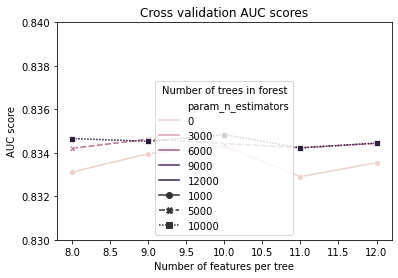

In [14]:
fig = sns.lineplot(x="param_max_features", y="mean_test_roc_auc", style="param_n_estimators", hue="param_n_estimators", 
    data=CV_grid, markers=True, err_style="bars", ci=100)
fig.set_title("Cross validation AUC scores")
fig.set(xlabel="Number of features per tree", ylabel="AUC score", title="Cross validation AUC scores", ylim=(0.83, 0.84))
fig.legend(title="Number of trees in forest");

### Build random forest classification model (all)

In [15]:
# fit RF to training data
rf_all = RandomForestClassifier(random_state=0, n_estimators=10000, max_features=10)
# rf_all = RandomForestClassifier(random_state=0, n_estimators=100, max_features=10) # only for testing
rf_all.fit(train_X_rob, train_y_balanced)

RandomForestClassifier(max_features=10, n_estimators=10000, random_state=0)

In [16]:
pred_y_all = rf_all.predict(test_X_rob)
pred_proba_y_all = rf_all.predict_proba(test_X_rob)

#### ROC curve

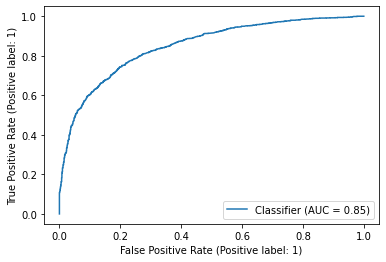

In [17]:
metrics.RocCurveDisplay.from_predictions(test_y, pred_proba_y_all[:, 1]);

#### Confusion matrix

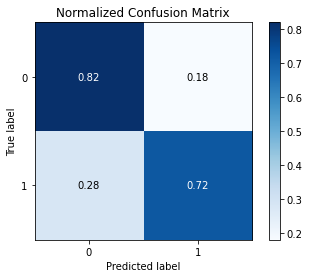

In [18]:
skplt.metrics.plot_confusion_matrix(test_y, pred_y_all, normalize=True);

#### Feature importance

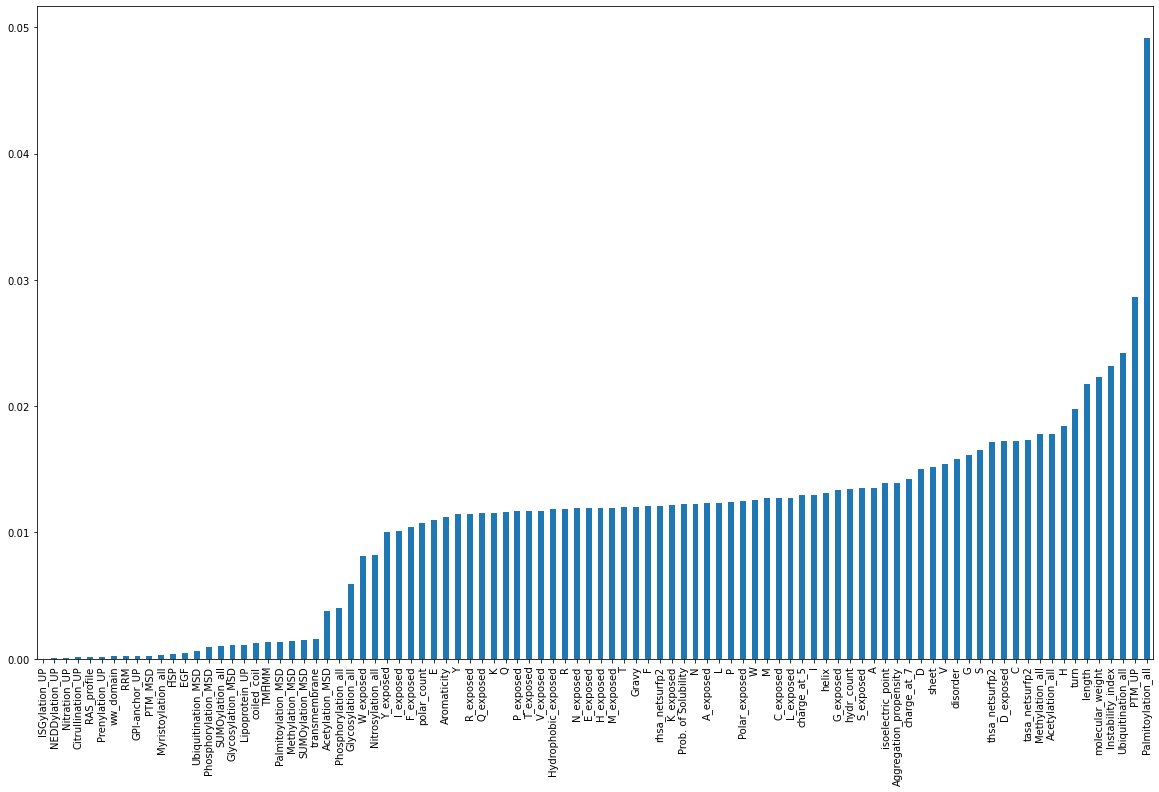

In [19]:
feature_importance = pd.Series(index = train_X_rob.columns, data = rf_all.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12))
feature_importance.to_csv(Data_path + '/MachineLearning/Feature_importance_RF_EV.csv', index=True)
fig = plt.gcf()

### Build random forest classification model (seq)

In [20]:
# use only sequence-based features
seq_features = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM',
                'TMHMM', 'Polar_exposed', 'Hydrophobic_exposed']

train_X_seq = train_X_rob[seq_features]
test_X_seq = test_X_rob[seq_features]

In [21]:
# fit RF to training data
rf_seq = RandomForestClassifier(random_state=0, n_estimators=10000, max_features=10)
rf_seq.fit(train_X_seq, train_y_balanced)
pred_y_seq = rf_seq.predict(test_X_seq)

In [22]:
pred_y_seq = rf_seq.predict(test_X_seq)
pred_proba_y_seq = rf_seq.predict_proba(test_X_seq)

In [23]:
# filepath = "/Models/"  

# # save the model 
# with open(filepath + 'RF_model_EV_seq.pkl', 'wb') as f:  
#     pickle.dump(rf_seq, f)
    
# # save the associated test data
# test_X_seq.to_csv('/Users/kathi/Documents/GitHub/EV/Models/test_X_EV_seq.csv', index=False)
# with open(filepath + 'test_y_EV_seq.pkl', 'wb') as f:  
#     np.save(f, test_y)

#### ROC plot

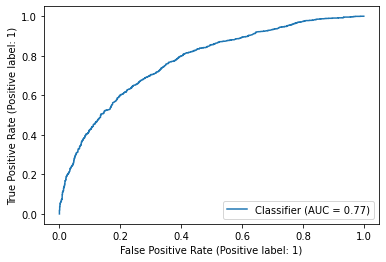

In [24]:
metrics.RocCurveDisplay.from_predictions(pd.Series(test_y), pd.Series(pred_proba_y_seq[:, 1]));

#### Confusion matrix

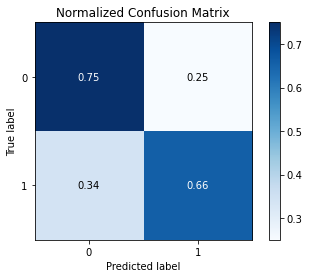

In [25]:
skplt.metrics.plot_confusion_matrix(test_y, pred_y_seq, normalize=True);

#### Feature importance

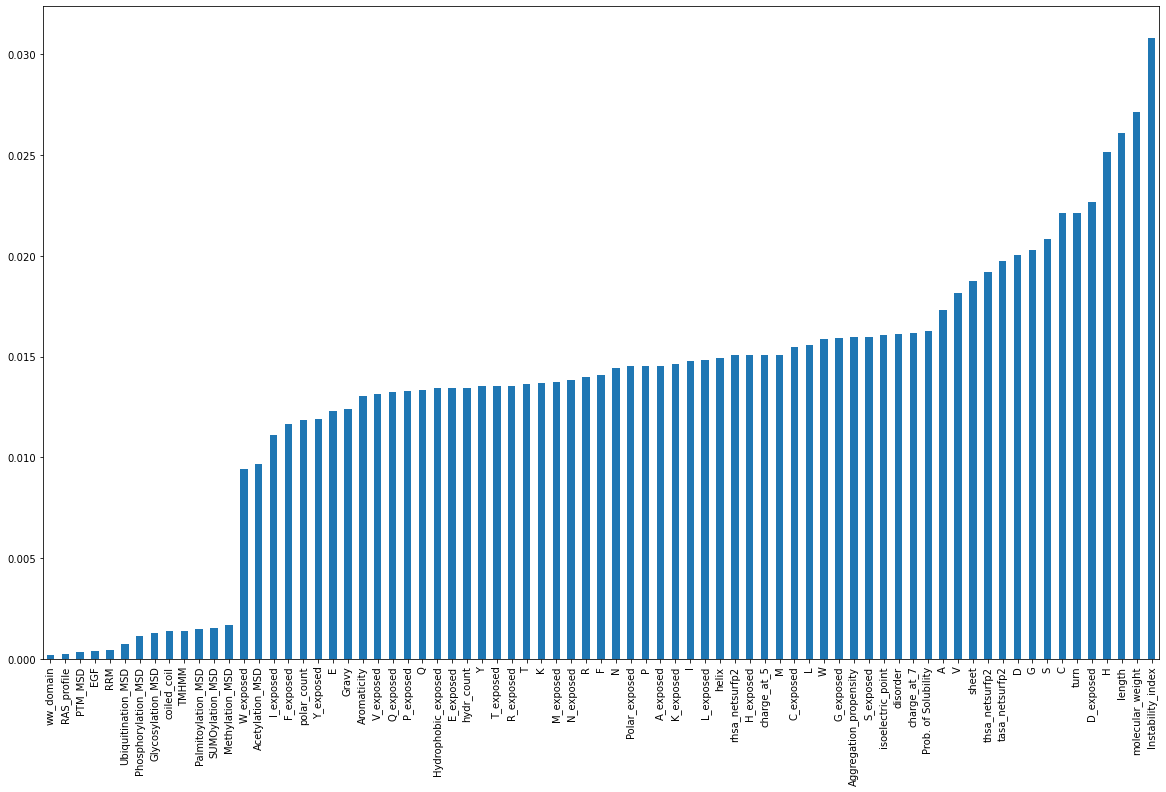

In [26]:
feature_importance = pd.Series(index = train_X_seq.columns, data = rf_seq.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12))
fig = plt.gcf()

# Save results

In [27]:
pd.Series(test_y).to_csv(Data_path + "/MachineLearning/test_y_EV.csv", index=False, header=False)
pd.Series(pred_proba_y_all[:, 1]).to_csv(Data_path + "/MachineLearning/pred_y_all_EV.csv", index=False, header=False)
pd.Series(pred_proba_y_seq[:, 1]).to_csv(Data_path + "/MachineLearning/pred_y_seq_EV.csv", index=False, header=False)